<a href="https://colab.research.google.com/github/TetraPlex-org/audiomerge/blob/main/AUDIOMERGE_FD_20230731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boilerplate

In [1]:
!git clone https://github.com/TetraPlex-org/audiomerge.git

Cloning into 'audiomerge'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 21 (delta 1), reused 6 (delta 0), pack-reused 11
Receiving objects: 100% (21/21), 85.89 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (10/10), done.


In [23]:
from operator import getitem
from pathlib import Path

import numpy as np
import pywt
import pandas as pd
from scipy import ndimage, stats, signal, integrate, interpolate
from scipy.signal import stft
from scipy.io import wavfile
import pywt
from skimage.restoration import denoise_wavelet

# for quick sketches
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, hlines, vlines, semilogy

# for professional visualization, publication quality
import plotnine as p9
from plotnine import ggplot, aes, element_blank

# initialization
from IPython.core.display import display, HTML
display(
    HTML(
        "<style>.container { width:80%; transform: translateX(130px); !important; }</style>"
    )
)
plt.rc("figure", figsize=(20, 20))

Pipes are awesome. Let's do more of those.

In [3]:
import ast
import inspect
from itertools import takewhile
from textwrap import dedent

class _PipeTransformer(ast.NodeTransformer):
    def visit_BinOp(self, node):
        if not isinstance(node.op, (ast.LShift, ast.RShift)):
            return node
        if not isinstance(node.right, ast.Call):
            return self.visit(
                ast.Call(
                    func=node.right,
                    args=[node.left],
                    keywords=[],
                    starargs=None,
                    kwargs=None,
                    lineno=node.right.lineno,
                    col_offset=node.right.col_offset,
                )
            )
        node.right.args.insert(0 if isinstance(node.op, ast.RShift) else len(node.right.args), node.left)
        return self.visit(node.right)

def pipes(func_or_class):
    if inspect.isclass(func_or_class):
        decorator_frame = inspect.stack()[1]
        ctx = decorator_frame[0].f_locals
        first_line_number = decorator_frame[2]
    else:
        ctx = func_or_class.__globals__
        first_line_number = func_or_class.__code__.co_firstlineno
    source = inspect.getsource(func_or_class)
    tree = ast.parse(dedent(source))
    ast.increment_lineno(tree, first_line_number - 1)
    source_indent = sum(1 for _ in takewhile(str.isspace, source)) + 1
    for node in ast.walk(tree):
        if hasattr(node, "col_offset"):
            node.col_offset += source_indent
    tree.body[0].decorator_list = [
        d
        for d in tree.body[0].decorator_list
        if isinstance(d, ast.Call) and d.func.id != "pipes" or isinstance(d, ast.Name) and d.id != "pipes"
    ]
    tree = _PipeTransformer().visit(tree)
    code = compile(tree, filename=(ctx["__file__"] if "__file__" in ctx else "repl"), mode="exec")
    exec(code, ctx)
    return ctx[tree.body[0].name]

def pipeprint(*args, **kwargs):
    print(*args, **kwargs)
    return args[0]

def convert_to_float(A):
    match A.dtype:
        case "int16":
            return A/(2**(16-1)-1)
        case "float64":
            # normalize to [-1, 1]
            A = (A - np.min(A)) / (np.max(A) - np.min(A))
            A = 2 * A - 1
            return A
        case _:
            raise NotImplementedError

# Experiment

In [4]:
rate_A, data_A = wavfile.read("audiomerge/examples/1/A.wav")
rate_B, data_B = wavfile.read("audiomerge/examples/1/B.wav")
rate_C, data_C = wavfile.read("audiomerge/examples/1/C.wav")
rate_D, data_D = wavfile.read("audiomerge/examples/1/D.wav")
rate_ref, data_ref = wavfile.read("audiomerge/examples/1/reference.wav")

data_A = convert_to_float(data_A)
data_B = convert_to_float(data_B)
data_C = convert_to_float(data_C)
data_D = convert_to_float(data_D)
data_ref = convert_to_float(data_ref)

In [5]:
rate_A, rate_B, rate_C, rate_D, rate_ref

(48000, 16000, 48000, 48000, 48000)

In [6]:
data_A.shape, data_B.shape, data_C.shape, data_D.shape, data_ref.shape

((7005312, 2), (2336768,), (7004160, 2), (6994944, 2), (2626560, 2))

In [7]:
data_A.dtype, data_B.dtype, data_C.dtype, data_D.dtype, data_ref.dtype

(dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [8]:
convert_to_float(data_A).max()

1.0

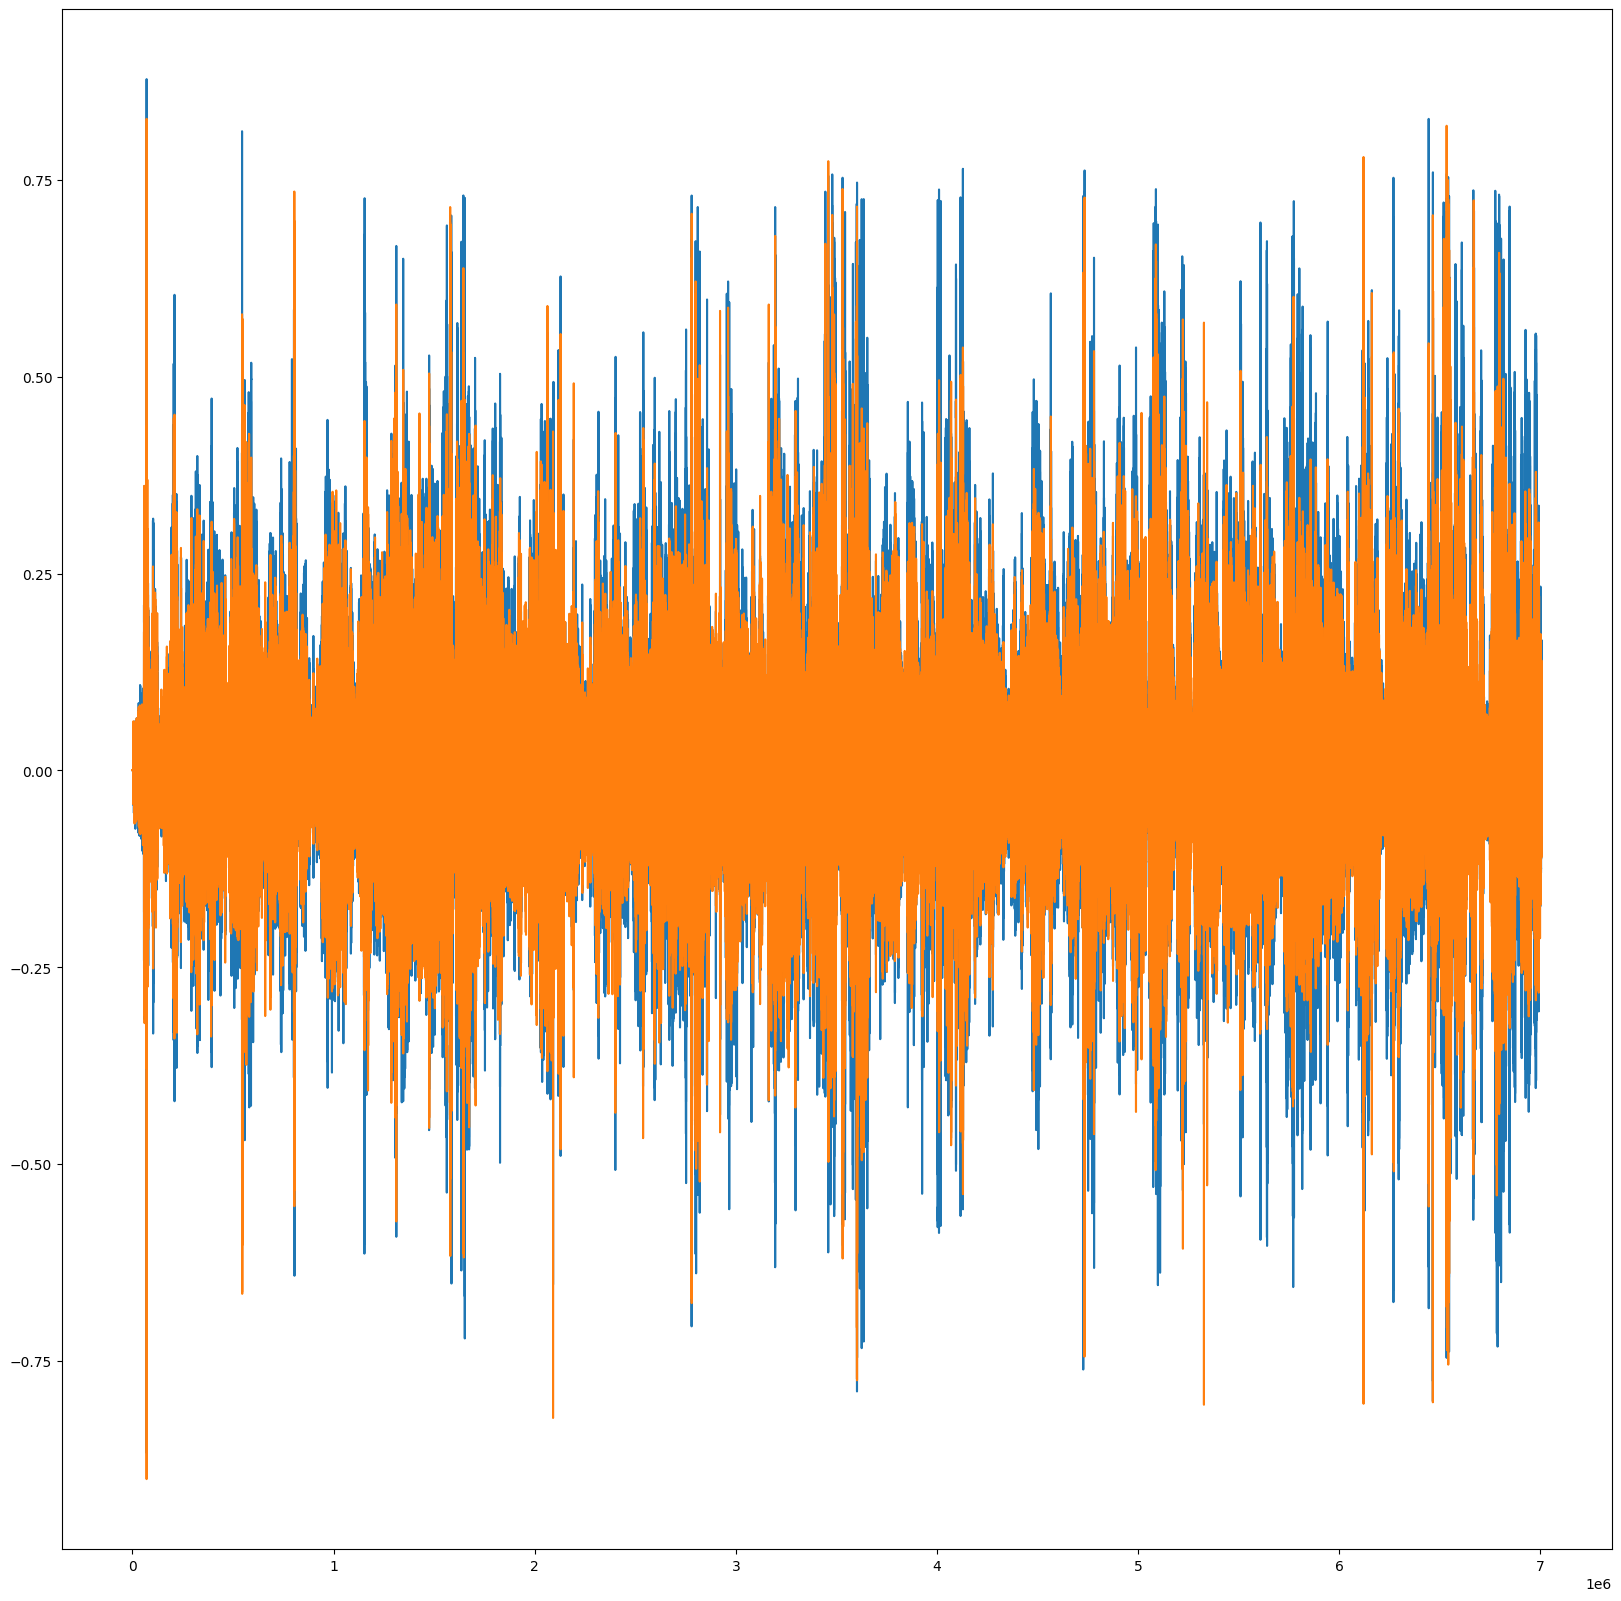

In [9]:
plot(data_A)

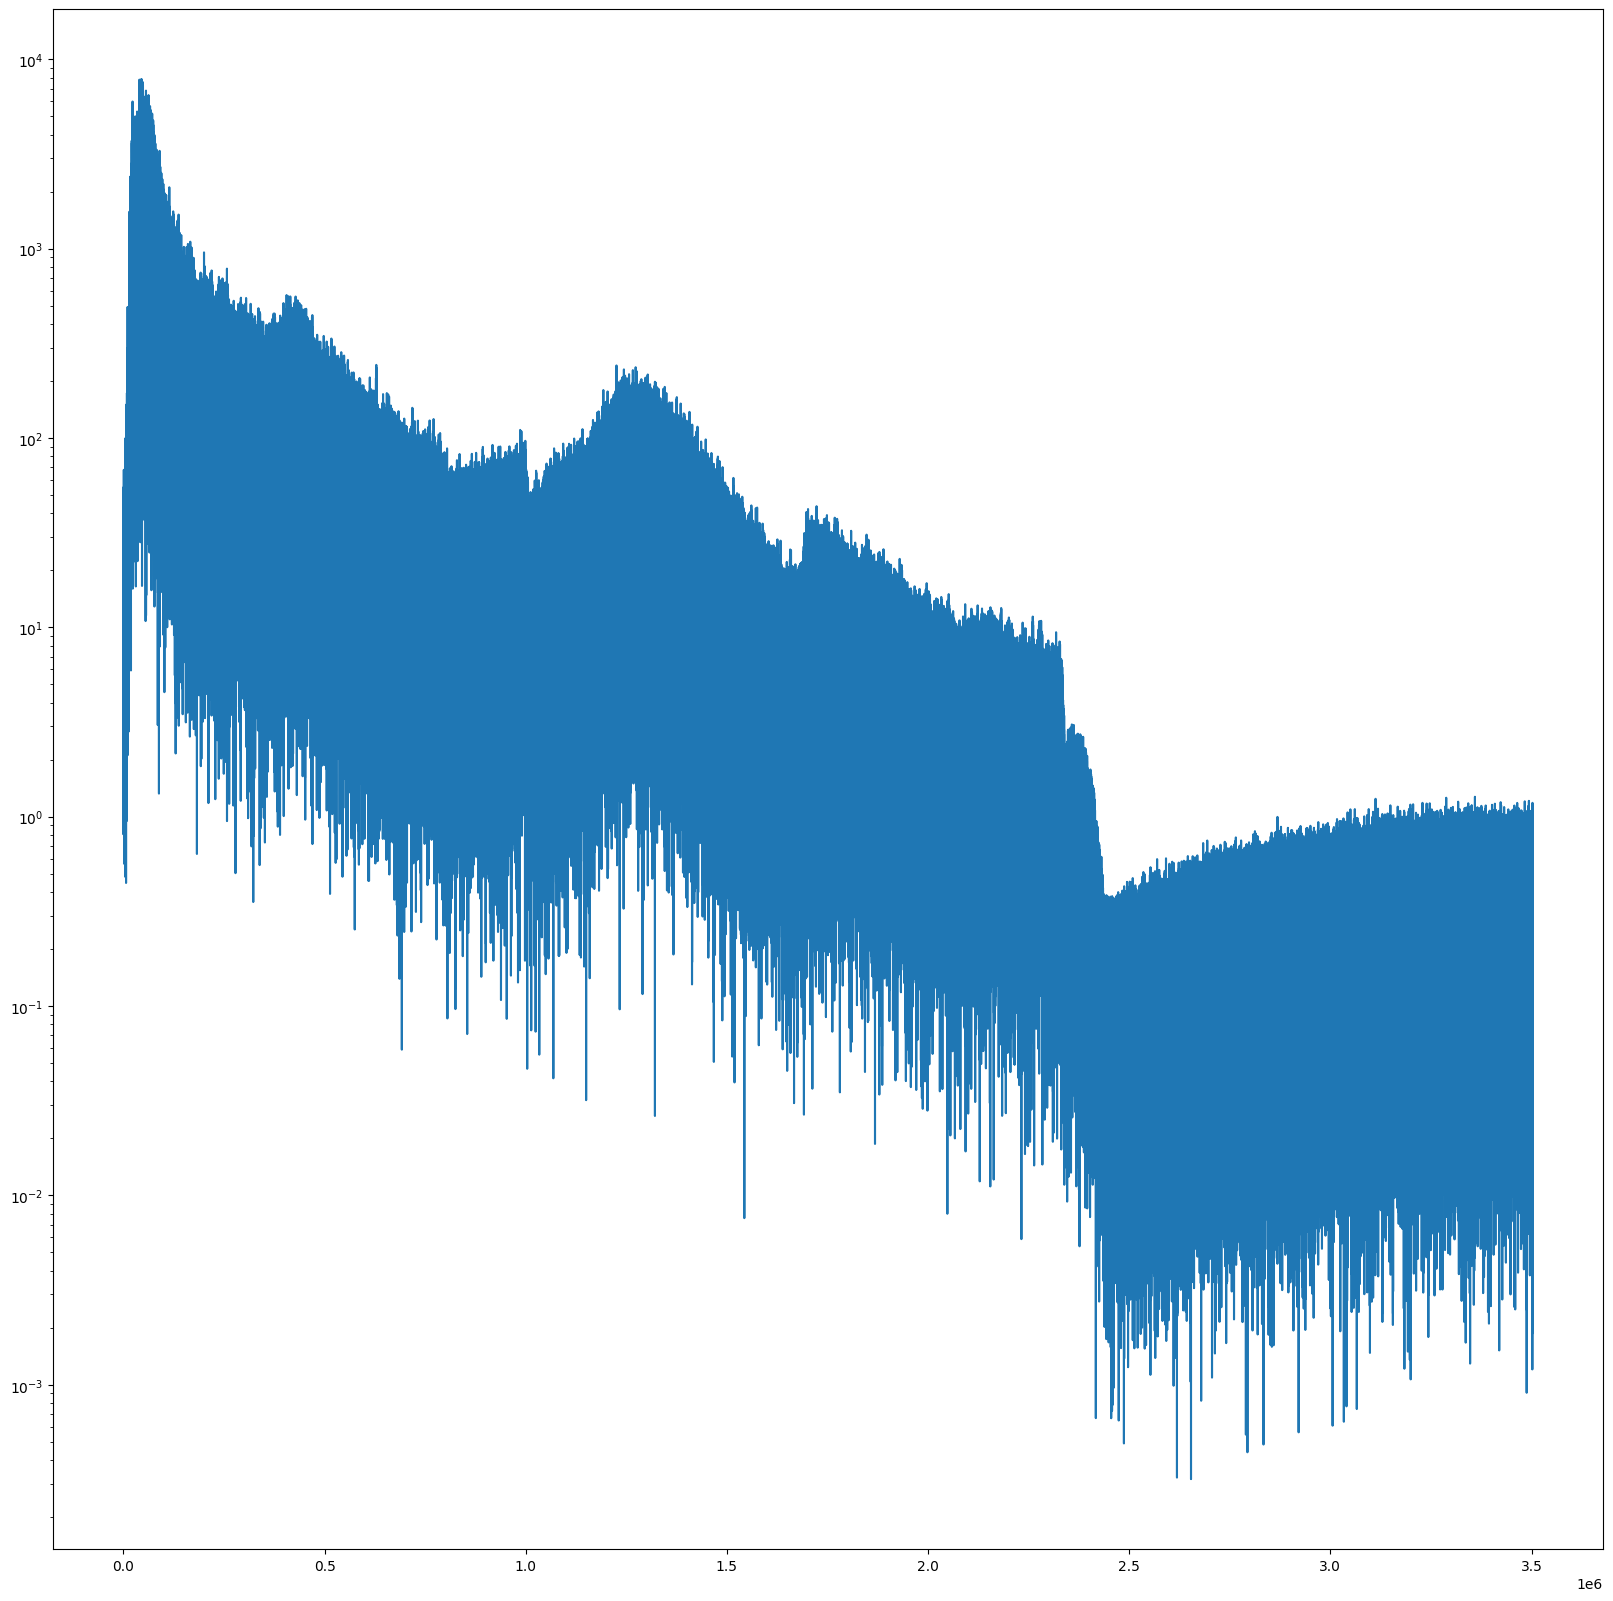

In [12]:
A = data_A[:,0][:]
@pipes
def _():
    ( A
    >> np.fft.fft
    >> np.abs
    >> getitem(slice(0, len(A)//2))
    >> semilogy
    )
_()

In [76]:
A = data_A[:rate_A*10,0]

f, t, Zxx = signal.stft(A, rate_A, nperseg=1000)

f.shape, t.shape, Zxx.shape, np.max(np.abs(Zxx)), np.min(np.abs(Zxx)), np.max(f), np.max(t)

((501,),
 (961,),
 (501, 961),
 0.13303021023988118,
 9.234756526144139e-11,
 24000.0,
 10.0)

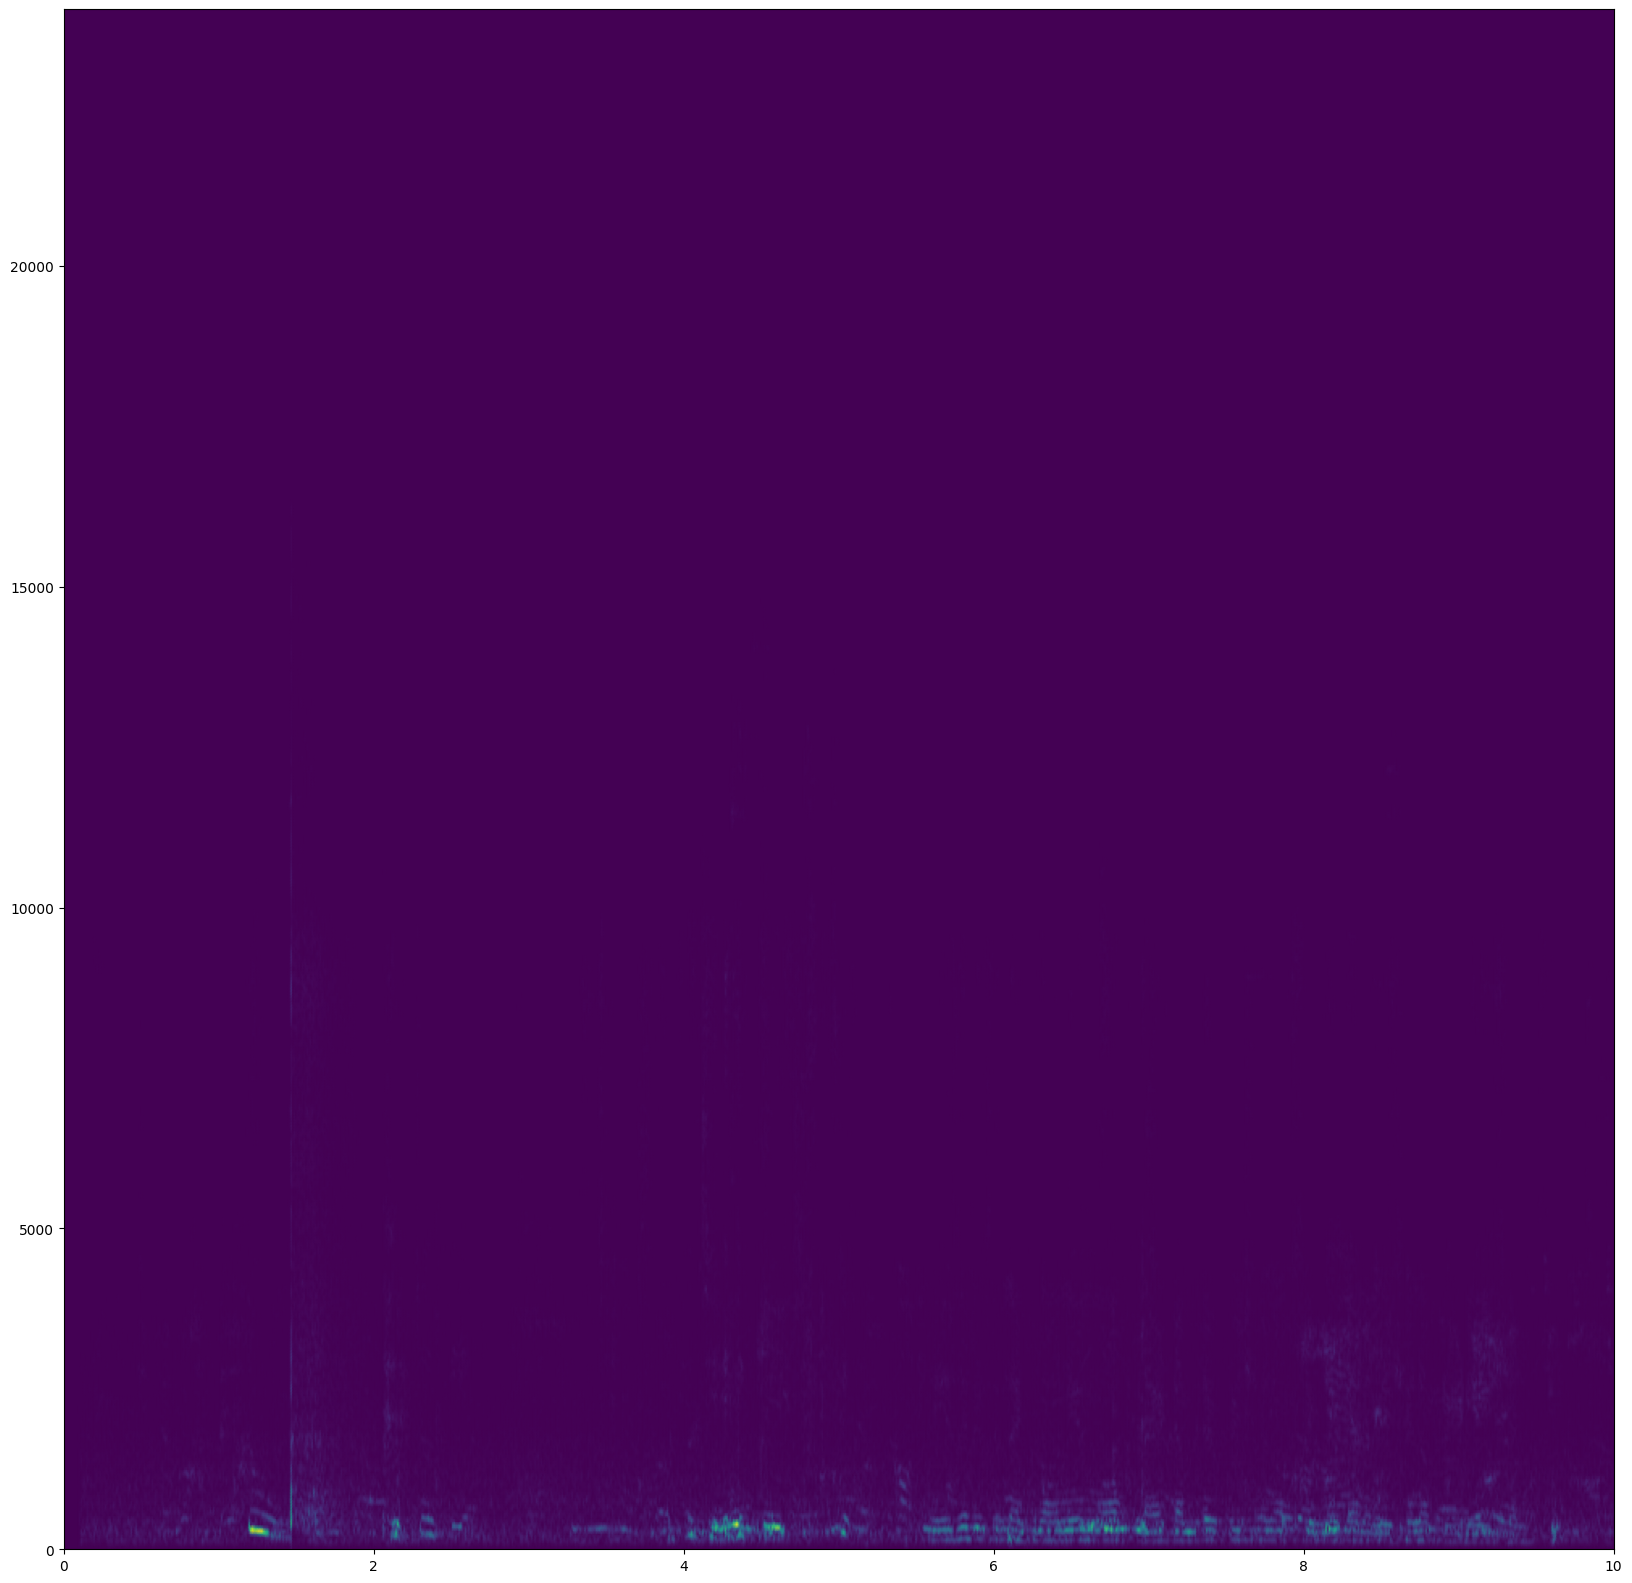

In [59]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')

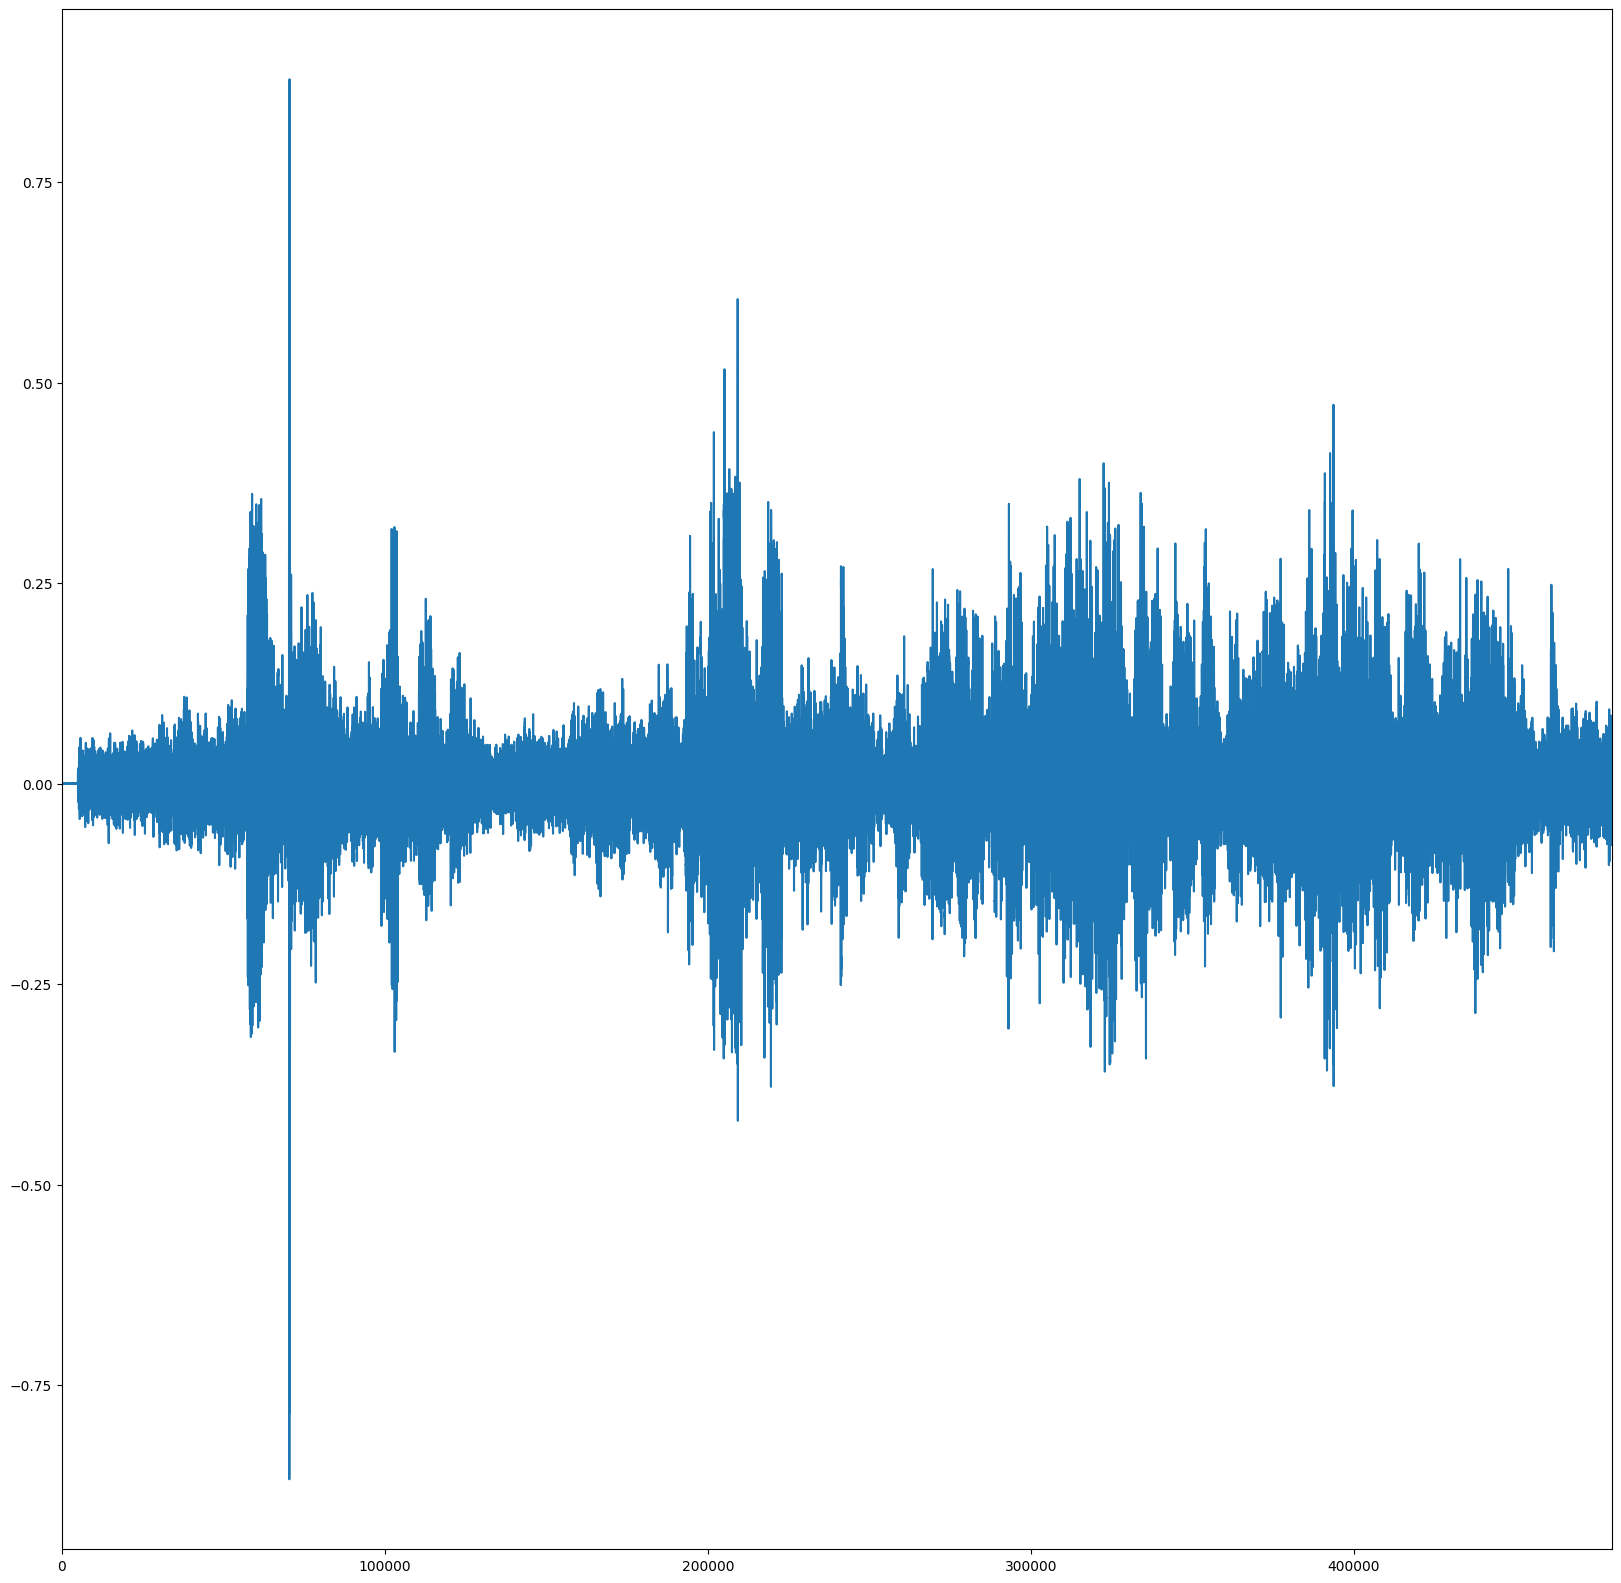

In [37]:
plt.margins(x=0)
A = data_A[0:rate_A*10,0]
@pipes
def _():
    ( A
    >> plot
    )
_()

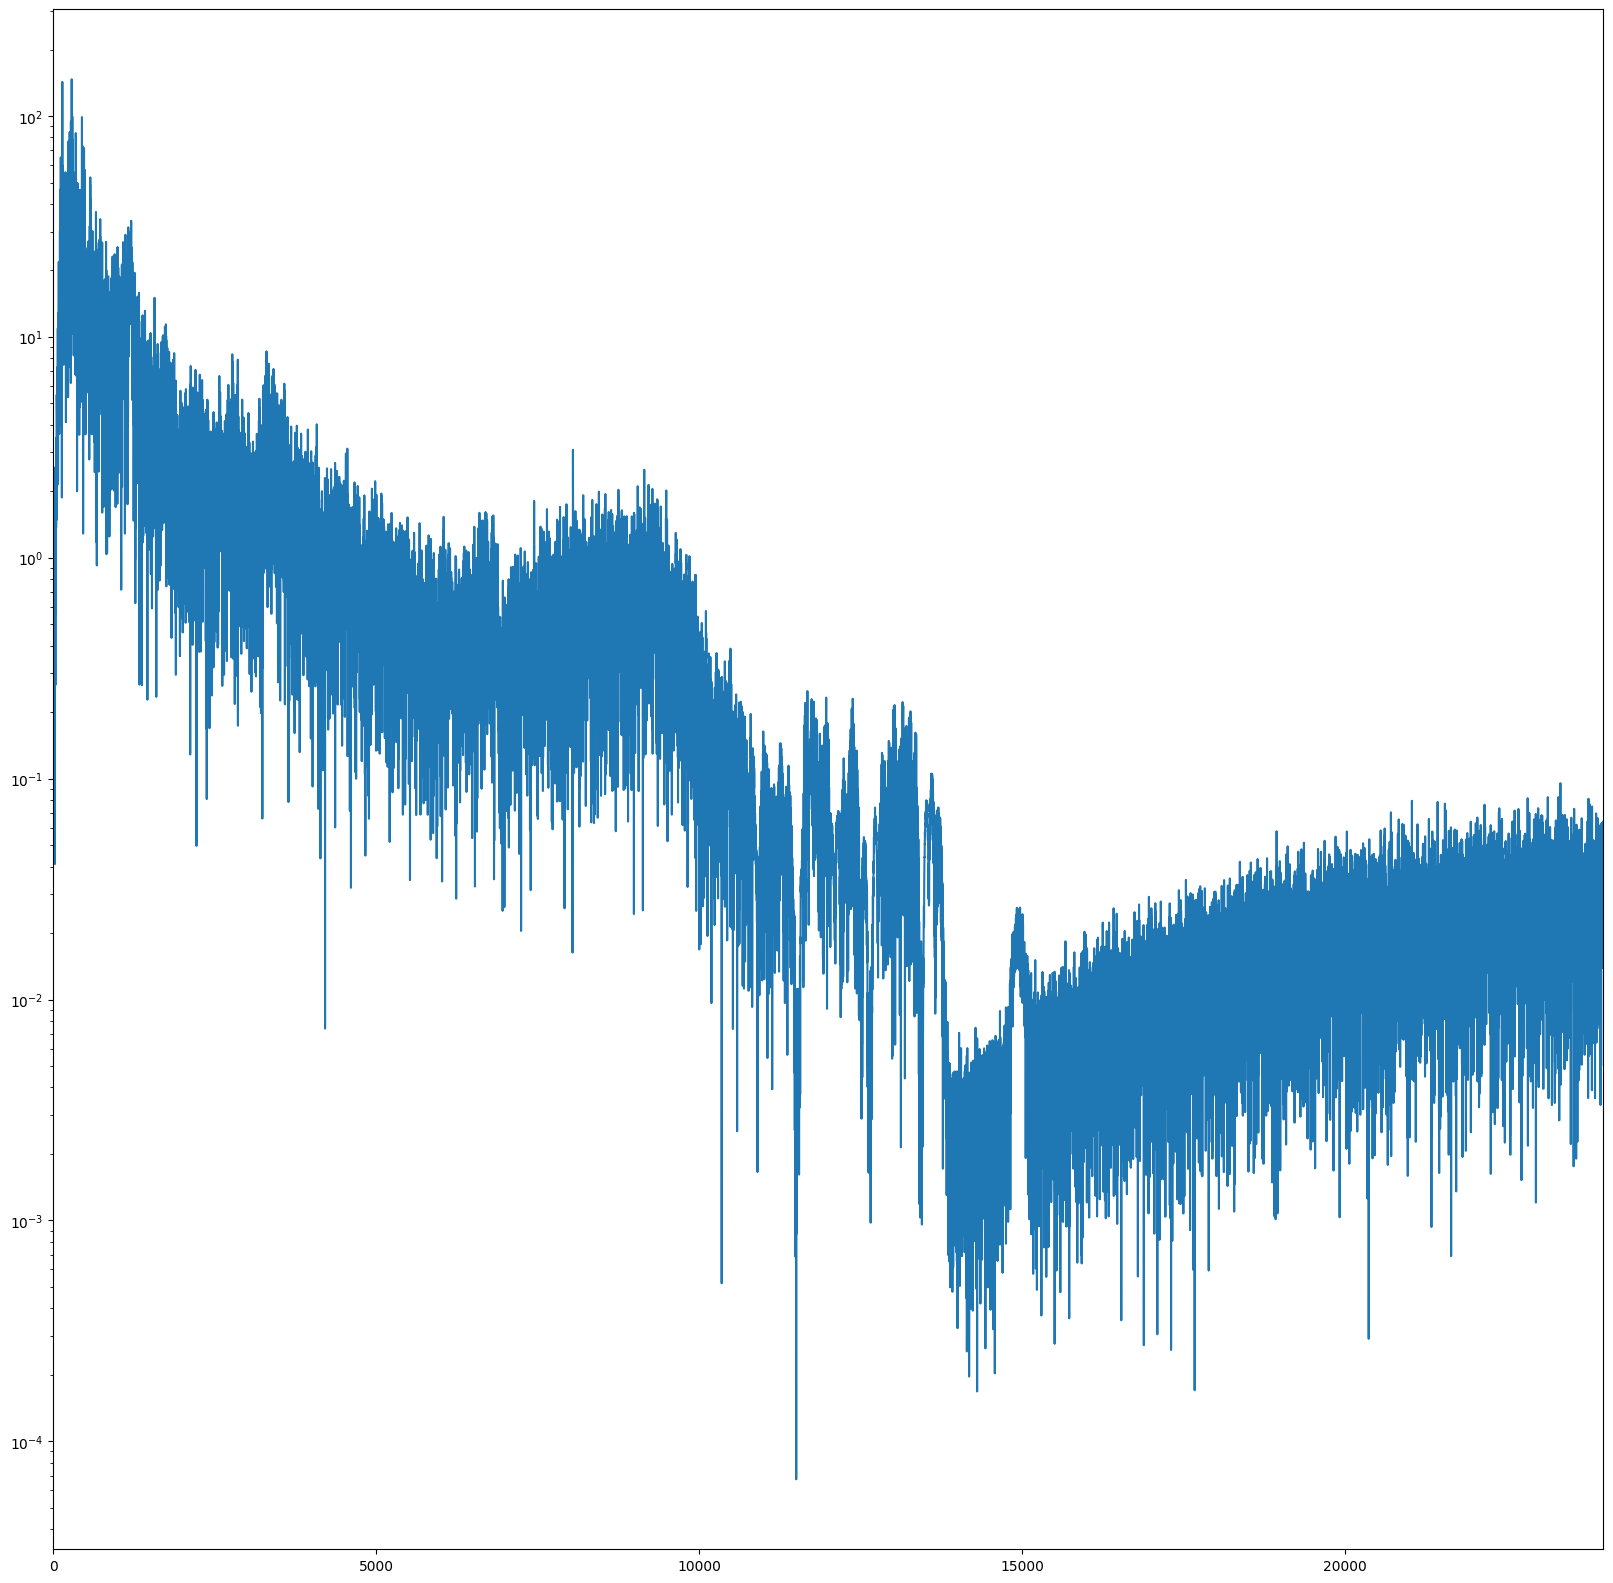

In [70]:
plt.margins(x=0)
n = 0
A = data_A[rate_A*n:rate_A*(n+1),0]
@pipes
def _():
    ( A
    >> np.fft.fft
    >> np.abs
    >> getitem(slice(0, len(A)//2))
    >> semilogy
    )
_()

In [51]:
A = data_A[:rate_A*10,0]
f, t, Zxx = signal.stft(A, rate_A, nperseg=1000)
f.shape, t.shape, Zxx.shape

((501,), (961,), (501, 961))

0.13303021023988118


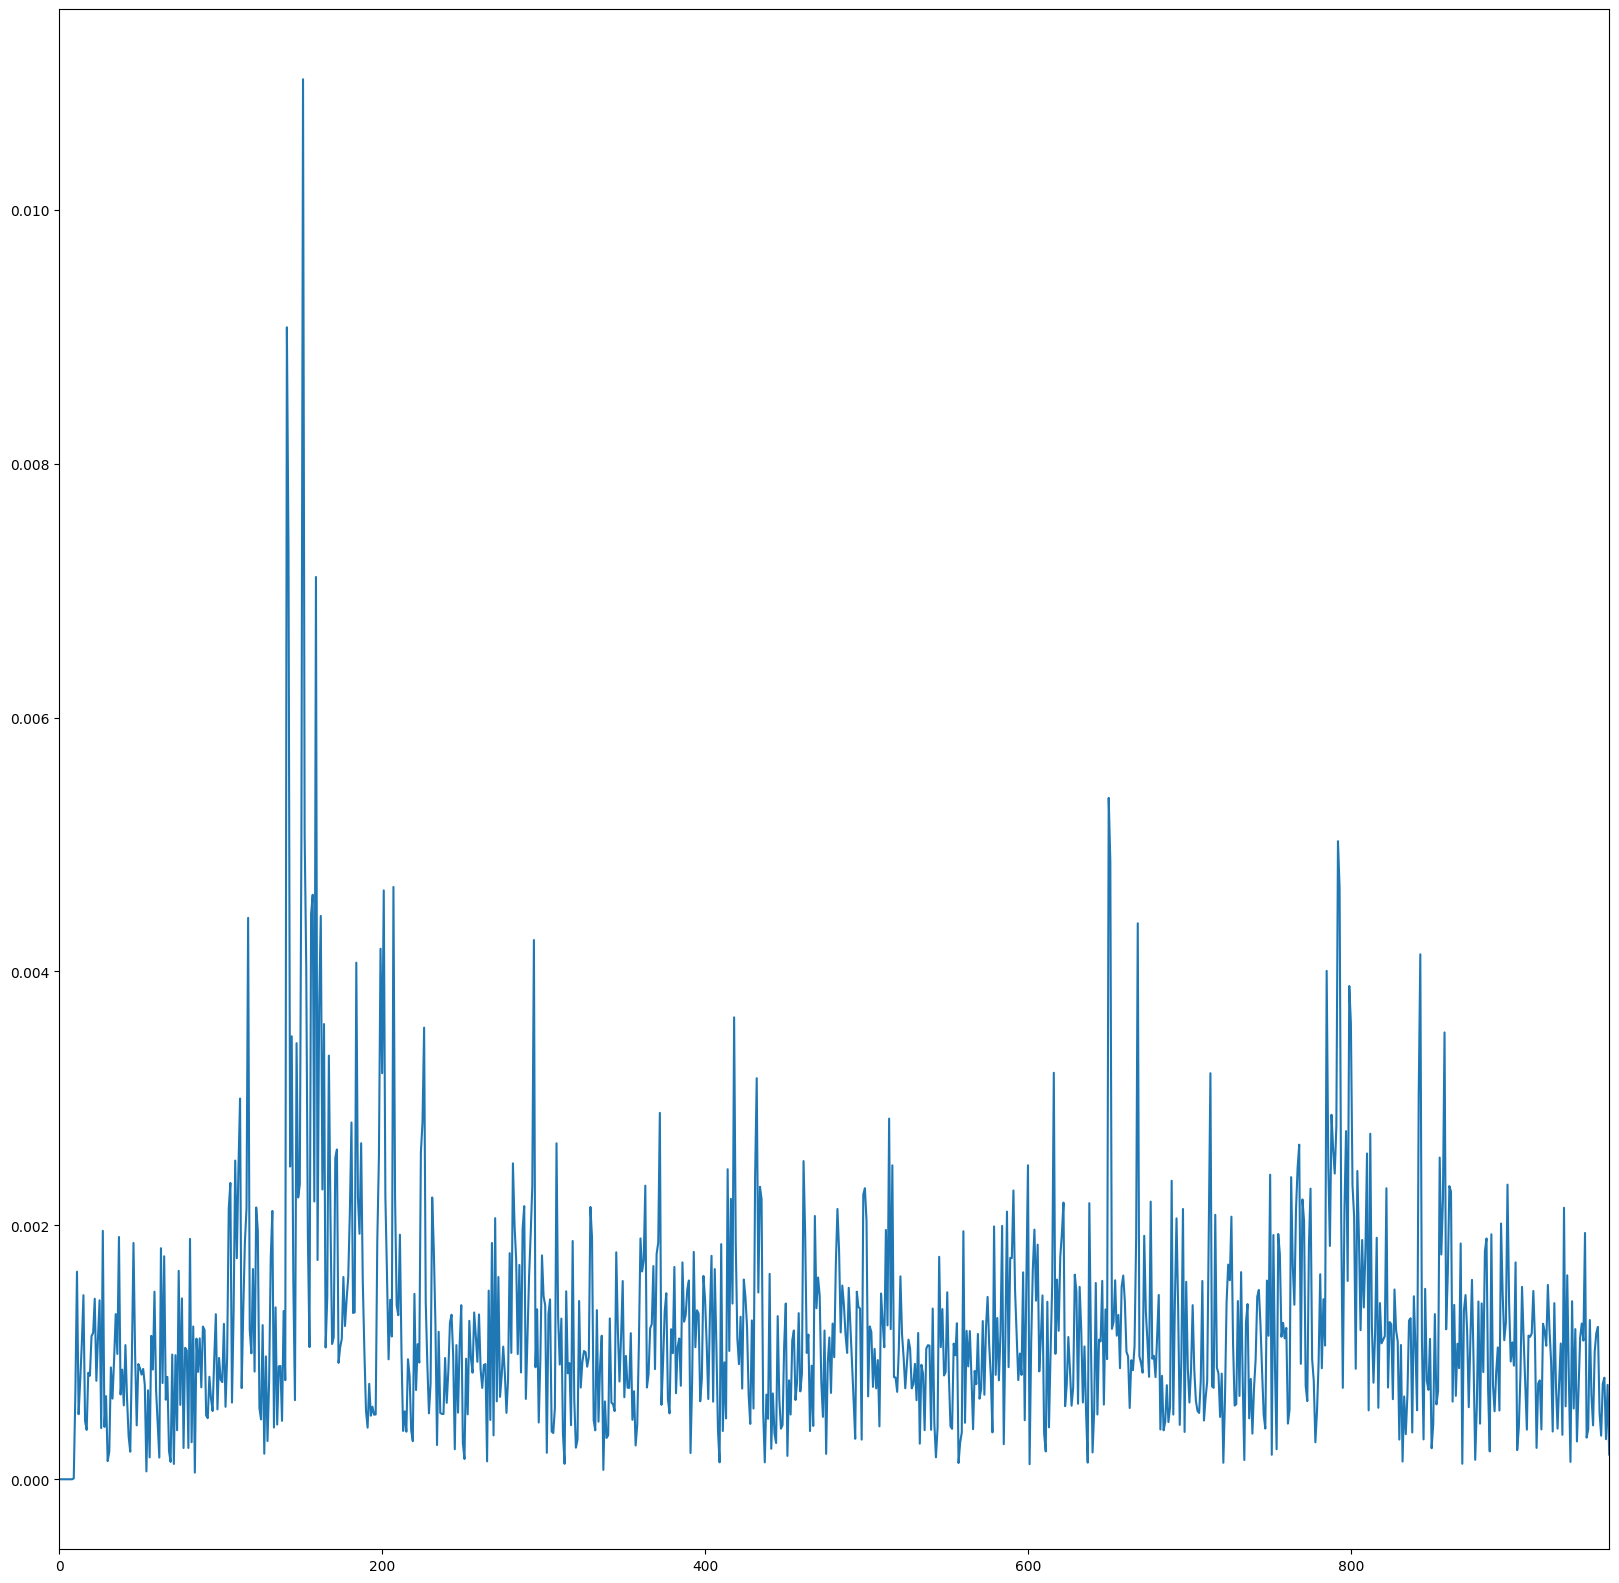

In [75]:
plt.margins(x=0)
print(np.max(np.abs(Zxx)))
plot(np.abs(Zxx)[30])

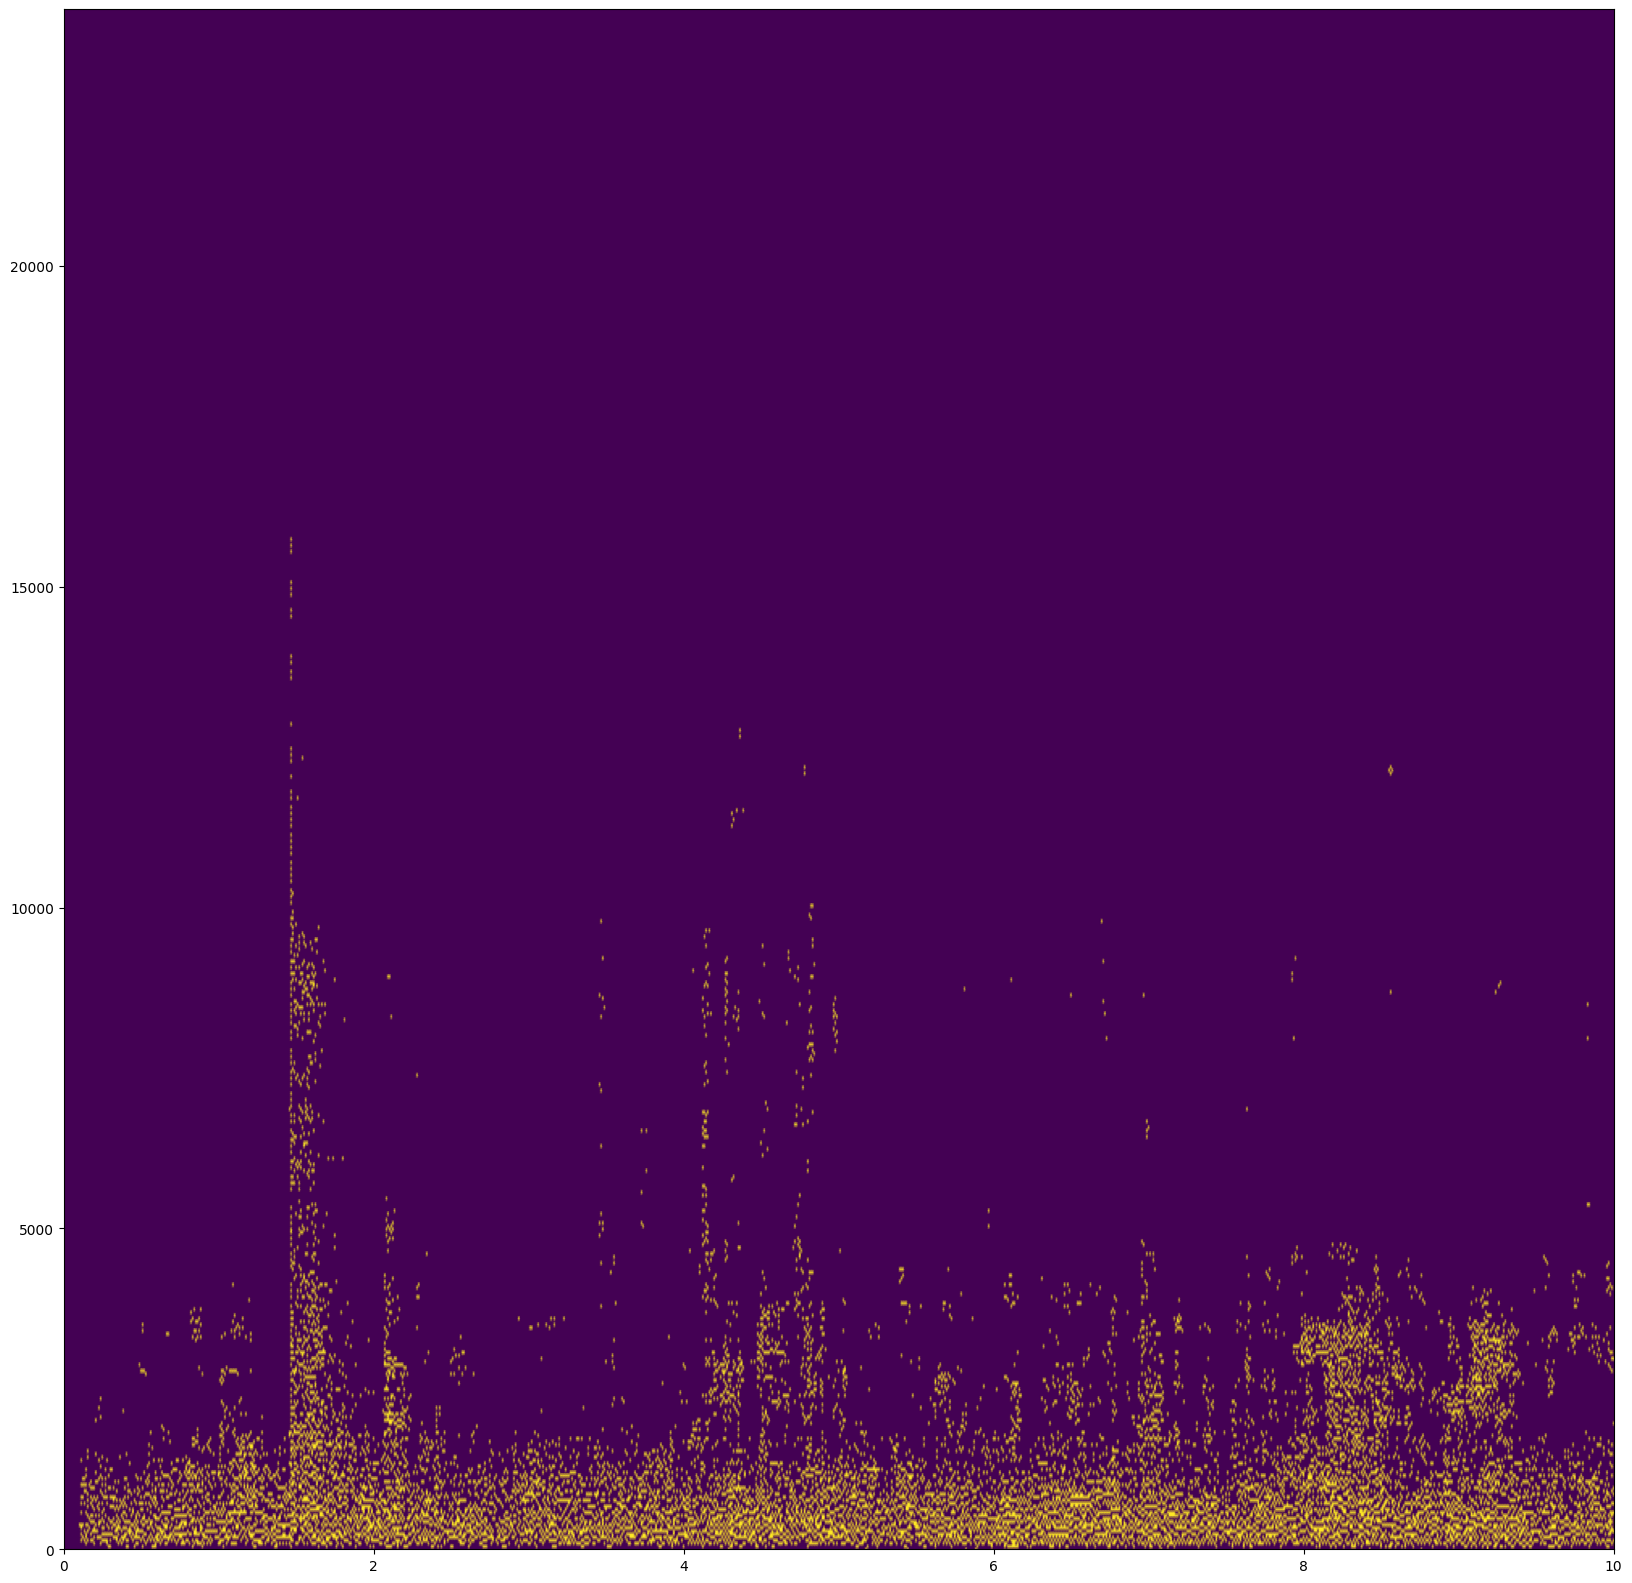

In [79]:
A = data_A[:rate_A*10,0]

f, t, Zxx = signal.stft(A, rate_A, nperseg=1000)
X = Zxx > 0.001

plt.pcolormesh(t, f, X, vmin=0, shading='gouraud')


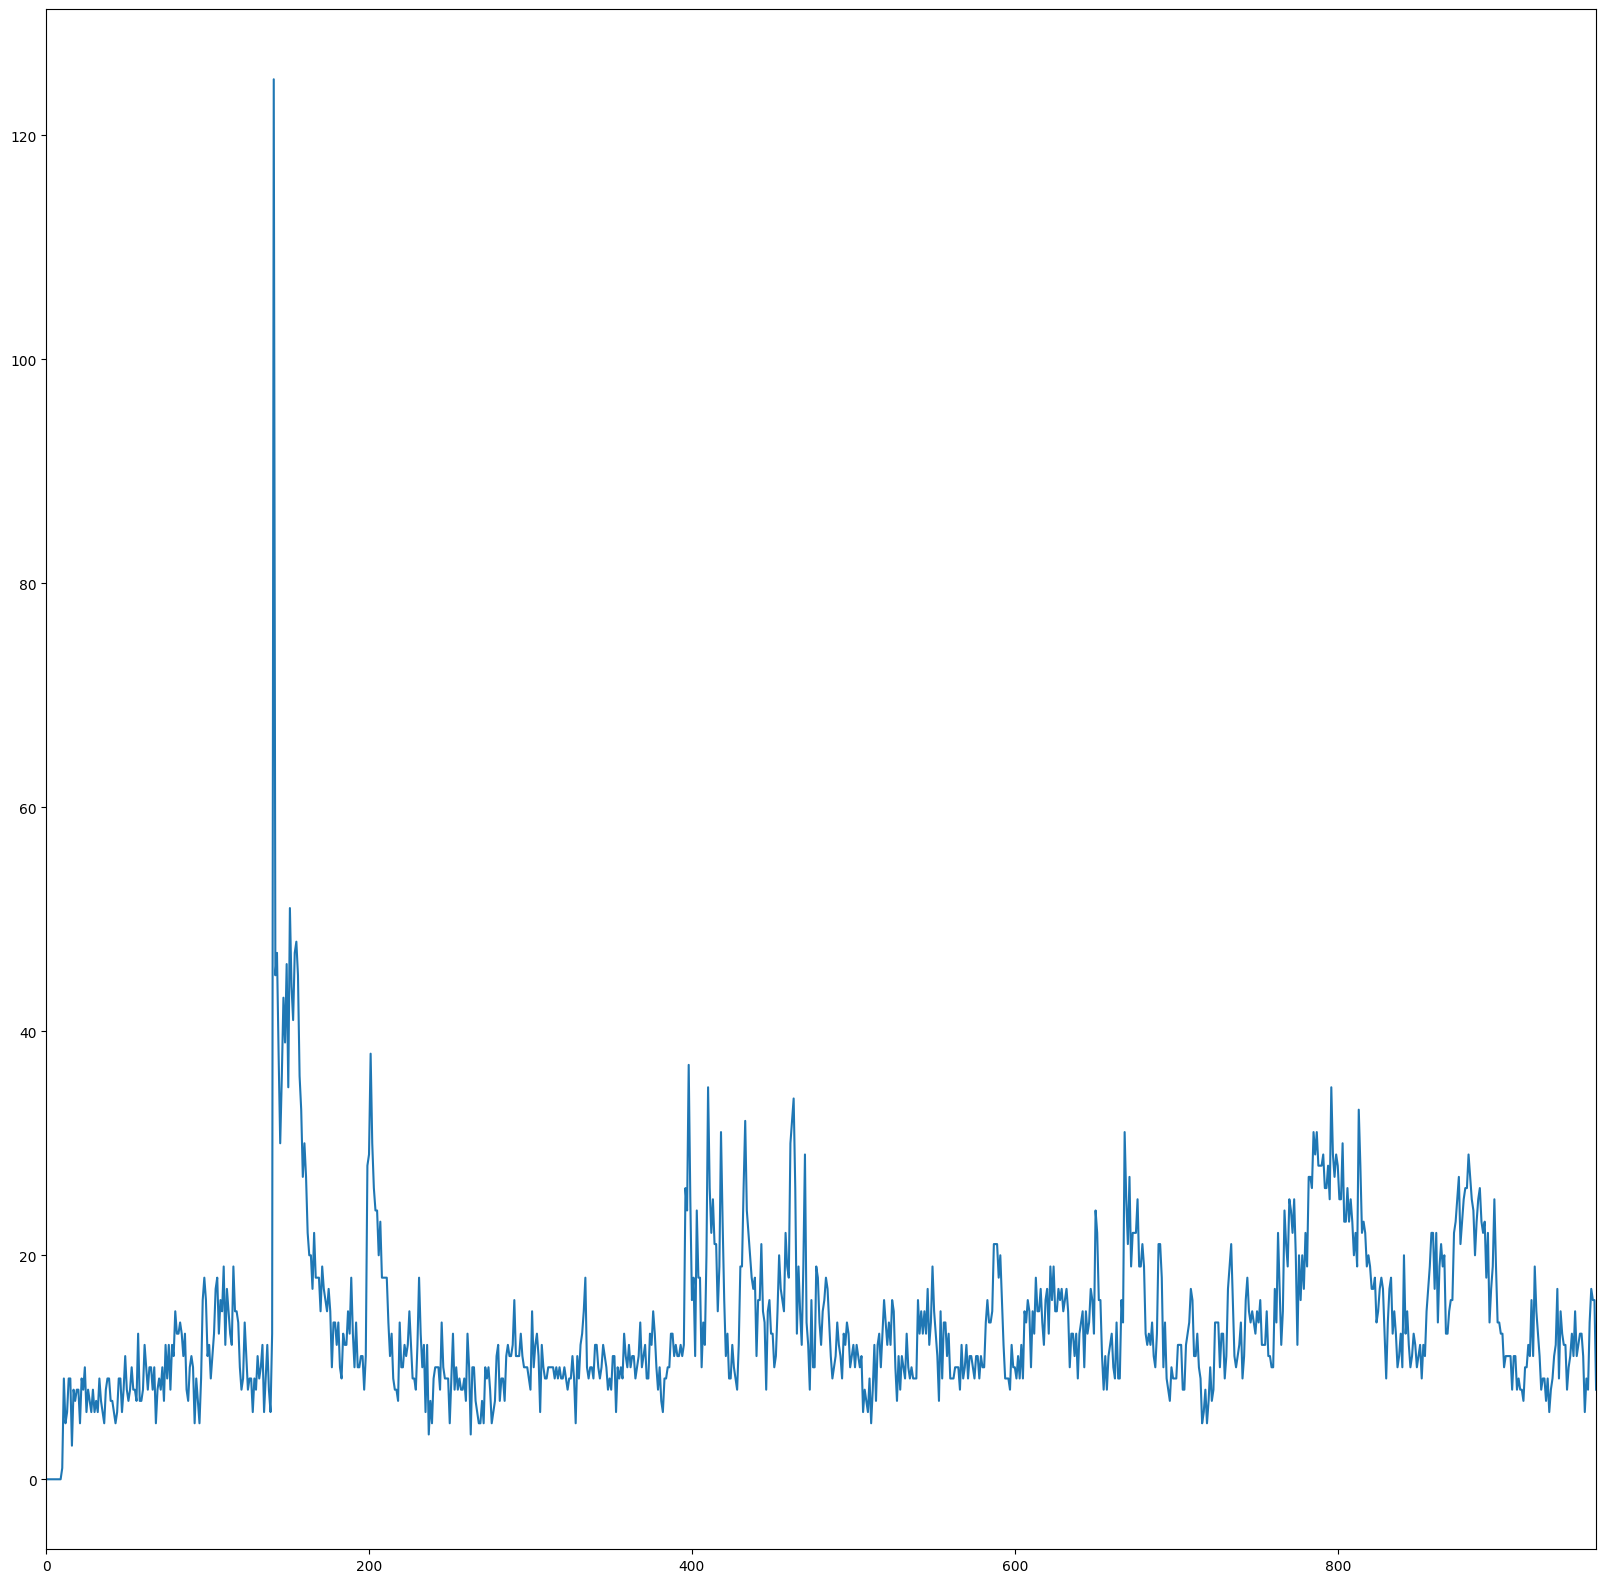

In [86]:
plt.margins(x=0)
A = data_A[:rate_A*10,0]

f, t, Zxx = signal.stft(A, rate_A, nperseg=1000)
X = Zxx > 0.001
plot(np.sum(X, axis=0))

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  3,  4,  3,  2,  3,  7,
        3,  3,  2,  6,  4,  4,  2,  3,  3,  3,  2,  1,  1,  5,  4,  4,  3,
        2,  3,  2,  3,  4,  1,  1,  5,  4,  3,  1,  2,  2,  4,  3,  1,  3,
        2,  3,  4,  3,  1,  1,  1,  3,  3,  2,  3,  4,  2,  2,  3,  4,  3,
        4,  3,  2,  3,  4,  2,  2,  2,  3,  3,  2,  5,  1,  2,  3,  2,  2,
        2,  1,  2,  4,  2,  3,  2,  3,  6,  4,  4,  2,  2,  3,  1,  4,  2,
        3,  4,  2,  2,  2,  2,  4,  5,  3,  4,  5,  2,  3,  5,  4,  2,  1,
        1,  3,  2,  2,  2,  4,  2,  3,  3,  5,  2,  3,  1,  1,  4,  2,  4,
        2,  4,  2,  4,  2,  1,  3,  6,  2,  2,  3,  4,  3,  2,  5,  2,  4,
        3,  2,  2,  2,  3,  1,  3,  2,  2,  2,  1,  3,  2,  2,  4,  4,  1,
        2,  5,  2,  1,  3,  3,  3,  2,  2,  7,  4,  1,  3,  2,  2,  4,  5,
        3,  2,  3,  1,  3,  1,  3,  3,  3,  2,  2,  4,  2,  1,  1,  1,  1,
        2,  2,  3,  1,  3,  2,  3,  1,  1,  1,  2,  2,  3,  4,  3,  2,  2,
        3,  2,  3,  3,  3

# End of Experiment - let's check the result!

In [ ]:
# data is now float64 instead of int16, which means x4 the original size!
wavfile.write("out1.wav", rate_A, data_A)
